In [10]:
!pip install pgmpy

In [17]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD


model = DiscreteBayesianNetwork([
    ('Burglary', 'Alarm'),
    ('Earthquake', 'Alarm'),
    ('Alarm', 'SeifoCalls'),
    ('Alarm', 'kamelCalls')
])

# CPDs
cpd_burglary = TabularCPD(
    variable='Burglary', variable_card=2,
    values=[[0.999], [0.001]]
)

cpd_earthquake = TabularCPD(
    variable='Earthquake', variable_card=2,
    values=[[0.998], [0.002]]
)

cpd_alarm = TabularCPD(
    variable='Alarm', variable_card=2,
    evidence=['Burglary', 'Earthquake'],
    evidence_card=[2, 2],
    values=[
        [0.999, 0.71, 0.06, 0.05],  # Alarm = 0
        [0.001, 0.29, 0.94, 0.95]   # Alarm = 1
    ]
)

cpd_seifo = TabularCPD(
    variable='SeifoCalls', variable_card=2,
    evidence=['Alarm'], evidence_card=[2],
    values=[[0.95, 0.05],
            [0.05, 0.95]]
)

cpd_karamel = TabularCPD(
    variable='kamelCalls', variable_card=2,
    evidence=['Alarm'], evidence_card=[2],
    values=[[0.99, 0.30],
            [0.01, 0.70]]
)

model.add_cpds(cpd_burglary, cpd_earthquake, cpd_alarm, cpd_seifo, cpd_karamel)

model.check_model()
print("Discrete Bayesian Network successfully created!")


Discrete Bayesian Network successfully created!


In [21]:
import pandas as pd
import itertools

def cpd_to_df(cpd):

    evidence = cpd.variables[1:]

    if not evidence:

        df = pd.DataFrame(cpd.values, columns=[cpd.variable])
        df.index = [f"{cpd.variable}=0", f"{cpd.variable}=1"]
        return df


    combos = list(itertools.product(*[range(c) for c in cpd.cardinality[1:]]))

    col_names = [
        ", ".join(f"{e}={v}" for e, v in zip(evidence, combo))
        for combo in combos
    ]


    reshaped_values = cpd.values.reshape(cpd.variable_card, -1)

    df = pd.DataFrame(reshaped_values, columns=col_names)
    df.index = [f"{cpd.variable}=0", f"{cpd.variable}=1"]
    return df

for cpd in model.get_cpds():
    print("\nCPD:", cpd.variable)
    display(cpd_to_df(cpd))


CPD: Burglary


,Burglary
Burglary=0,0.999
Burglary=1,0.001



CPD: Earthquake


,Earthquake
Earthquake=0,0.998
Earthquake=1,0.002



CPD: Alarm


,"Burglary=0, Earthquake=0","Burglary=0, Earthquake=1","Burglary=1, Earthquake=0","Burglary=1, Earthquake=1"
Alarm=0,0.999,0.71,0.06,0.05
Alarm=1,0.001,0.29,0.94,0.95



CPD: SeifoCalls


,Alarm=0,Alarm=1
SeifoCalls=0,0.95,0.05
SeifoCalls=1,0.05,0.95



CPD: kamelCalls


,Alarm=0,Alarm=1
kamelCalls=0,0.99,0.3
kamelCalls=1,0.01,0.7


In [22]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)

queries = [
    ('Burglary', {}),
    ('Alarm', {}),
    ('Burglary', {'SeifoCalls': 1, 'kamelCalls': 1}),
    ('Burglary', {'SeifoCalls': 1}),
    ('Burglary', {'kamelCalls': 1}),
]

for var, evidence in queries:
    q = infer.query([var], evidence=evidence)
    print(f"\nP({var} | {evidence})")
    print(q)



P(Burglary | {})
+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.9990 |
+-------------+-----------------+
| Burglary(1) |          0.0010 |
+-------------+-----------------+

P(Alarm | {})
+----------+--------------+
| Alarm    |   phi(Alarm) |
+==========+==============+
| Alarm(0) |       0.9975 |
+----------+--------------+
| Alarm(1) |       0.0025 |
+----------+--------------+

P(Burglary | {'SeifoCalls': 1, 'kamelCalls': 1})
+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.7122 |
+-------------+-----------------+
| Burglary(1) |          0.2878 |
+-------------+-----------------+

P(Burglary | {'SeifoCalls': 1})
+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.9829 |
+-------------+-----------------+
| Burglary(1) |          0.0171 |
+-------

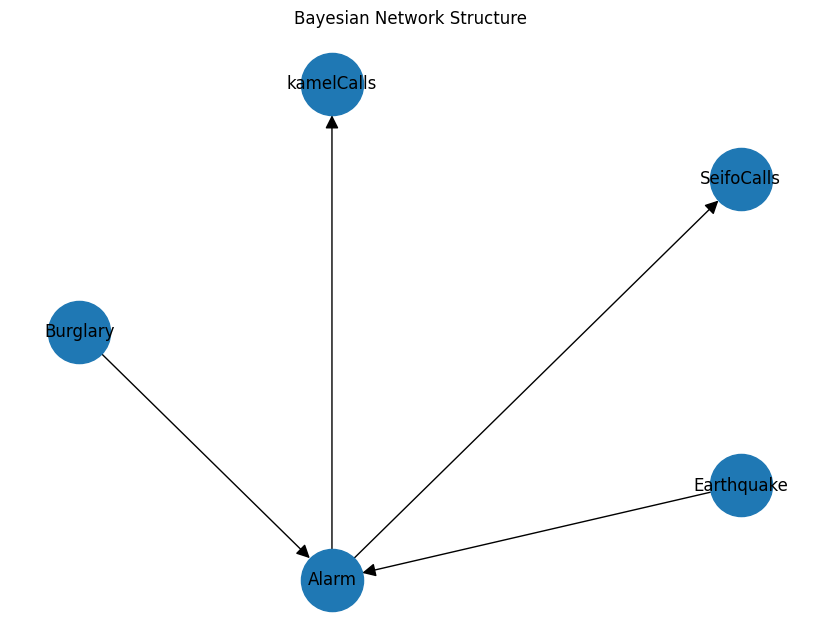

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
G = model

pos = nx.shell_layout(G)

nx.draw(G, pos, with_labels=True, node_size=2000, font_size=12, arrowsize=20)
plt.title("Bayesian Network Structure")
plt.show()